In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

from urllib.parse import urlencode
from urllib.request import urlretrieve

import numpy as np
import numpy.core.defchararray as np_f
import pandas as pd
import scipy as sci
from scipy.stats import f
from scipy.stats import kde
from subprocess import *
import os
import glob
from pathlib import Path
import re

from astropy.table import Table
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
from astropy import coordinates as coords

import importlib
import tqdm

import time

import warnings

import ResearchTools.LCtools as LCtools
import VarStar_Vi_plot_functions as vi

from astropy.timeseries import LombScargle
from sklearn.cluster import MeanShift, estimate_bandwidth

In [2]:
importlib.reload(vi)

<module 'VarStar_Vi_plot_functions' from '/Users/benjaminroulston/Dropbox/GitHub/TDSS-Variable-Star-ViP/VarStar_Vi_plot_functions.py'>

In [3]:
importlib.reload(LCtools)

<module 'ResearchTools.LCtools' from '/Users/benjaminroulston/Dropbox/Research/Coding/python_codes/ResearchTools/LCtools.py'>

In [4]:
spec_dir = "/Users/benjaminroulston/Dropbox/Research/TDSS/Variable_Stars/HARD_COPY_ORGINAL_DATA/SDSS_spec/02-26-2020/SDSSspec/"
CSS_LC_dir = "/Users/benjaminroulston/Dropbox/Research/TDSS/Variable_Stars/HARD_COPY_ORGINAL_DATA/CSS_LCs/csvs/"
ZTF_LC_dir = "/Users/benjaminroulston/Dropbox/Research/TDSS/Variable_Stars/HARD_COPY_ORGINAL_DATA/ZTF/DATA/06-24-2020/"

ZTF_filters = ['g', 'r']
ZTF_LC_file_names = [f'TDSS_SES+PREV_DR16DR12griLT20_GAIADR2_Drake2014PerVar_ZTF_{ZTF_filter}_epochGT10_GroupID.fits' for ZTF_filter in ZTF_filters]
ZTF_g_LCs = Table.read(ZTF_LC_dir + ZTF_LC_file_names[0])
ZTF_r_LCs = Table.read(ZTF_LC_dir + ZTF_LC_file_names[1])

In [5]:
prop_out_dir, CSS_LC_plot_dir, ZTF_LC_plot_dir, Vi_plots_dir, datestr = vi.makeViDirs()
nbins = 50
TDSSprop = vi.TDSSprop(nbins)
latestFullVartoolsRun_filename = "completed_Vi_prop_2020-07-16.csv"
latestFullVartoolsRun = vi.latestFullVartoolsRun(prop_out_dir + latestFullVartoolsRun_filename)

In [6]:
hasViRun, prop_id_last, properties = vi.checkViRun()  # if Vi has run, this will find where it let off and continue propid from there

prop_col_names_prefix = ['CSS_', 'ZTF_g_', 'ZTF_r_']
if hasViRun:
    pass
else:
    prop_id = 0
    prop_id_last = 0
    prop_col_names = ['lc_id', 'P', 'logProb', 'Amp', 'Mt', 'a95', 'lc_skew',
                      'Chi2', 'brtcutoff', 'brt10per', 'fnt10per', 'fntcutoff', 'errmn', 'ferrmn',
                      'ngood', 'nrejects', 'nabove', 'nbelow', 'Tspan100', 'Tspan95', 'isAlias', 'time_whittened',
                      'VarStat', 'Con', 'm', 'b_lin', 'chi2_lin', 'a', 'b_quad', 'c', 'chi2_quad']

    prop_col_names_full = [ii + jj for ii in prop_col_names_prefix for jj in prop_col_names]
    prop_col_names_full.insert(0, 'ViCompleted')
    prop_col_names_full.insert(0, 'dec')
    prop_col_names_full.insert(0, 'ra')
    prop_col_names_full.append('EqW')

    properties = np.zeros((len(TDSSprop.data), len(prop_col_names_full)))

    properties = Table(properties, names=prop_col_names_full)
    properties['ra'] = TDSSprop.data['ra']
    properties['dec'] = TDSSprop.data['dec']

In [6]:
runLS = True
plotLCerr = True
plt_resid = False
plt_subLC = True
plot_rejected = False
checkHarmonic = True
logProblimit = -10
Nepochs_required = 10
minP = 0.1
maxP = 100.0
nterms_LS = 1

In [169]:
prop = Table.read("/Users/benjaminroulston/Dropbox/Research/TDSS/Variable_Stars/HARD_COPY_ORGINAL_DATA/PROGRAM_SAMPLE/2020-06-24/FINAL_FILES/TDSS_SES+PREV_DR16DR12griLT20_GAIADR2_Drake2014PerVar_VSX_CSSID_ZTFIDs_LCpointer_PyHammer_VI_ALLPROP_07-27-2020.fits")

In [8]:
prop

<Table masked=True length=23595>
         ra                  dec           ra_hhmmss   ... Period_VSX u_Period
                                                       ...     d              
      float64              float64          bytes13    ...  float64    bytes3 
-------------------- ------------------- ------------- ... ---------- --------
0.013060618227171972 -2.4300805538428953 00:00:03.1345 ...   0.493647         
0.014713355887636226   20.15233972699837 00:00:03.5312 ...        nan         
0.027163333332509865  26.081956257827894 00:00:06.5192 ...        nan         
 0.03462988082492302   0.524964809875049 00:00:08.3112 ...        nan         
 0.03713044097406737   25.89781983915267 00:00:08.9113 ...        nan         
 0.04023406009048358   5.772161822786031 00:00:09.6562 ...        nan         
  0.0443658988150446  20.125803798939895 00:00:10.6478 ...        nan         
 0.04566644494445882   33.45150060523772 00:00:10.9599 ...        nan         
0.047414550813186906  26.922966491625953 00:00:11.3795 ...        nan         
                 ...                 ...           ... ...        ...      ...
  359.95195705091464  24.522676533369665 23:59:48.4697 ...        nan         
  359.95343760295253  18.443369256584077 23:59:48.8250 ...        nan         
   359.9579336011982  11.283692450896034 23:59:49.9041 ...        nan         
  359.96483784228616  26.540218478232095 23:59:51.5611 ...        nan         
  359.97067197726585  26.557666044941904 23:59:52.9613 ...        nan         
   359.9764011880136  23.086317430721994 23:59:54.3363 ...        nan         
   359.9785444622639  23.935111993994028 23:59:54.8507 ...        nan         
   359.9826815387359   6.114361008287686 23:59:55.8436 ...        nan         
  359.98335471465765  23.593915979450497 23:59:56.0051 ...        nan         
  359.99734312574867  1.8076620019365974 23:59:59.3624 ...        nan

In [9]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result


def freq2per(frequency, period_unit=u.d):
    return (frequency**-1).to(period_unit)


def per2freq(period, frequency_unit=u.microHertz):
    return (period**-1).to(frequency_unit)


In [150]:
prop_id = 5 # 12
ROW = TDSSprop.data[prop_id]

object_ra = ROW['ra']
object_dec = ROW['dec']
ra_string = '{:0>9.5f}'.format(object_ra)
dec_string = '{:0=+9.5f}'.format(object_dec)

is_CSS = ROW['CSSLC']
is_ZTF_g = np.isfinite(ROW['ZTF_g_GroupID'])
is_ZTF_r = np.isfinite(ROW['ZTF_r_GroupID'])

if is_CSS:
    lc_file = CSS_LC_dir+str(ROW['CSSID'])+'.dat'
    CSS_lc_data = Table.read(lc_file, format='ascii', names=['mjd', 'mag', 'magerr'])
    CSS_lc_data.sort('mjd')
if is_ZTF_g:
    ZTF_g_lc_data = ZTF_g_LCs[(ZTF_g_LCs['GroupID'] == ROW['ZTF_g_GroupID'])]['mjd', 'mag', 'magerr']
    ZTF_g_lc_data.sort('mjd')
if is_ZTF_r:
    ZTF_r_lc_data = ZTF_r_LCs[(ZTF_r_LCs['GroupID'] == ROW['ZTF_r_GroupID'])]['mjd', 'mag', 'magerr']
    ZTF_r_lc_data.sort('mjd')

print(ra_string, dec_string)
print(is_CSS, is_ZTF_g, is_ZTF_r)
print(len(CSS_lc_data), len(ZTF_g_lc_data), len(ZTF_r_lc_data))

000.04023 +05.77216
True -- --
383 110 123


In [151]:
flc_data, LC_stat_properties = LCtools.process_LC(CSS_lc_data, fltRange=5.0)

In [152]:
goodQualIndex = np.where(flc_data['QualFlag'] == True)[0]
lc_mjd = flc_data['mjd'][goodQualIndex]
lc_mag = flc_data['mag'][goodQualIndex]
lc_err = flc_data['magerr'][goodQualIndex]

t_days = lc_mjd * u.day
y_mags = lc_mag * u.mag
dy_mags = lc_err * u.mag

P_range = [0.1 * u.d, np.inf * u.d]
Nf = 250000  # Number of frequencuies to check

minP = P_range[0].to(u.d)
maximum_frequency = (minP)**-1

maxP = P_range[1].to(u.d)
minimum_frequency = (maxP)**-1

freq_grid = np.linspace(minimum_frequency.value, maximum_frequency.value, num=Nf + 1)[1:] / u.d

ls_window = LombScargle(t_days, np.ones(y_mags.size), fit_mean=False, center_data=False)
window_power = ls_window.power(frequency=freq_grid)
window_power[~np.isfinite(window_power)] = 0
window_FAP_power_peak = np.nanstd(window_power).value * 4


ls = LombScargle(t_days, y_mags, dy_mags, fit_mean=True, center_data=True)
power = ls.power(frequency=freq_grid)
logFAP_limit = -10
FAP_power_peak = ls.false_alarm_level(10**logFAP_limit)
df = (1 * u.d)**-1

P = freq2per(freq_grid[np.argmax(power)]).value 
FAP = ls.false_alarm_probability(power.max())
print(f"The period with the largest period is: P = {P}d.")
print(f"The corosponding log10(FAP) is: los10(FAP) = {np.log10(FAP)}")

The period with the largest period is: P = 0.32337343163885657d.
The corosponding log10(FAP) is: los10(FAP) = -36.02949446277989


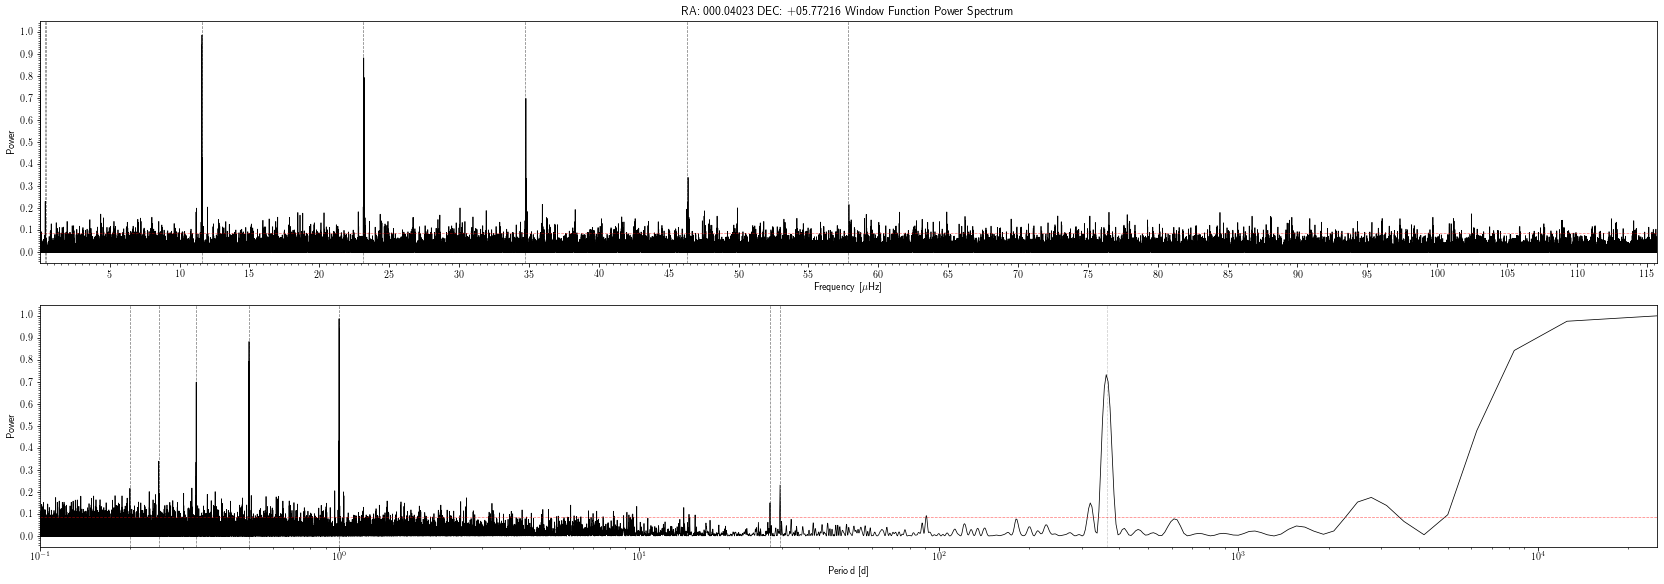

In [153]:
title = 'RA: {!s} DEC: {!s} Window Function Power Spectrum'.format(ra_string, dec_string)
LCtools.plot_powerspec(freq_grid, window_power, FAP_power_peak=window_FAP_power_peak, title=title)

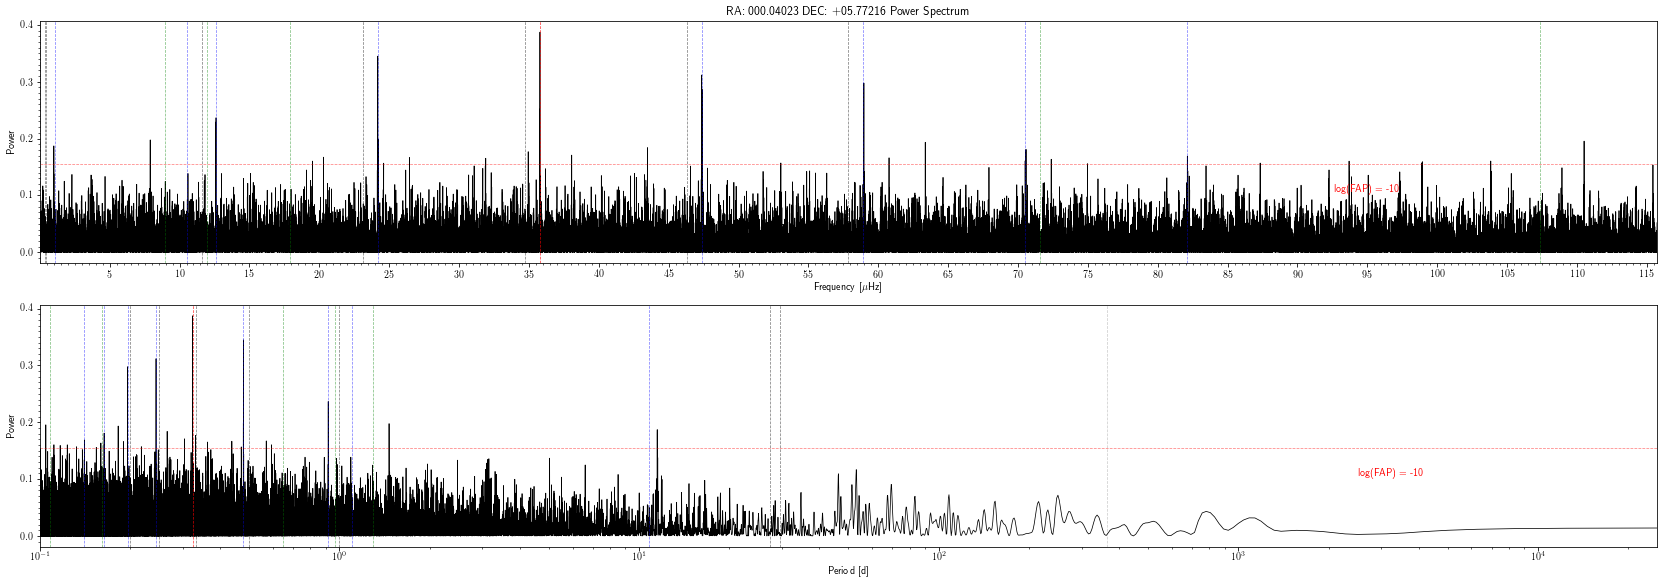

In [154]:
title = 'RA: {!s} DEC: {!s} Power Spectrum'.format(ra_string, dec_string)
LCtools.plot_powerspec(freq_grid, power, FAP_power_peak=FAP_power_peak, logFAP_limit=logFAP_limit, alias_df=df, title=title)

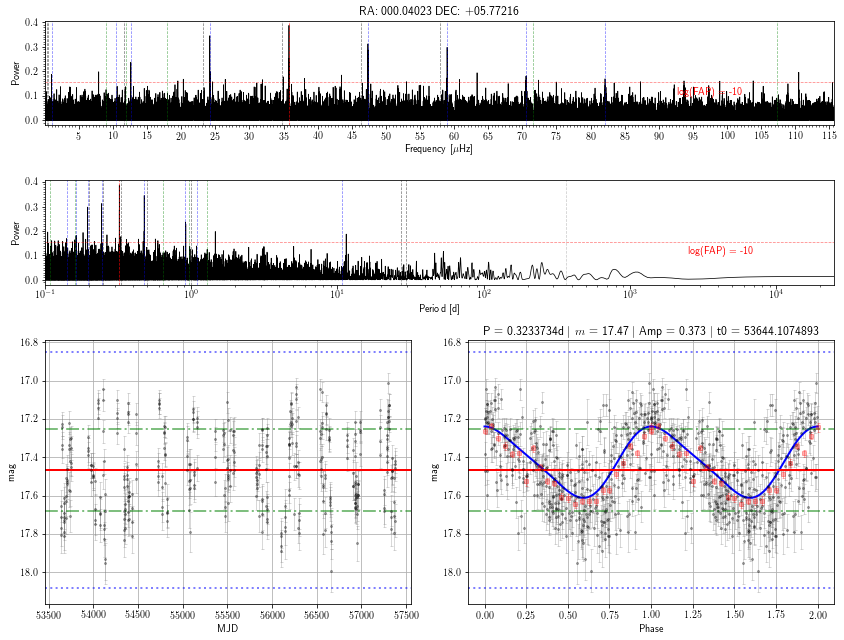

In [155]:
title = "RA: {!s} DEC: {!s}".format(ra_string, dec_string)
LCtools.plot_LC_analysis(flc_data, P, freq_grid, power, FAP_power_peak=FAP_power_peak, logFAP_limit=logFAP_limit, df=df, title=title)

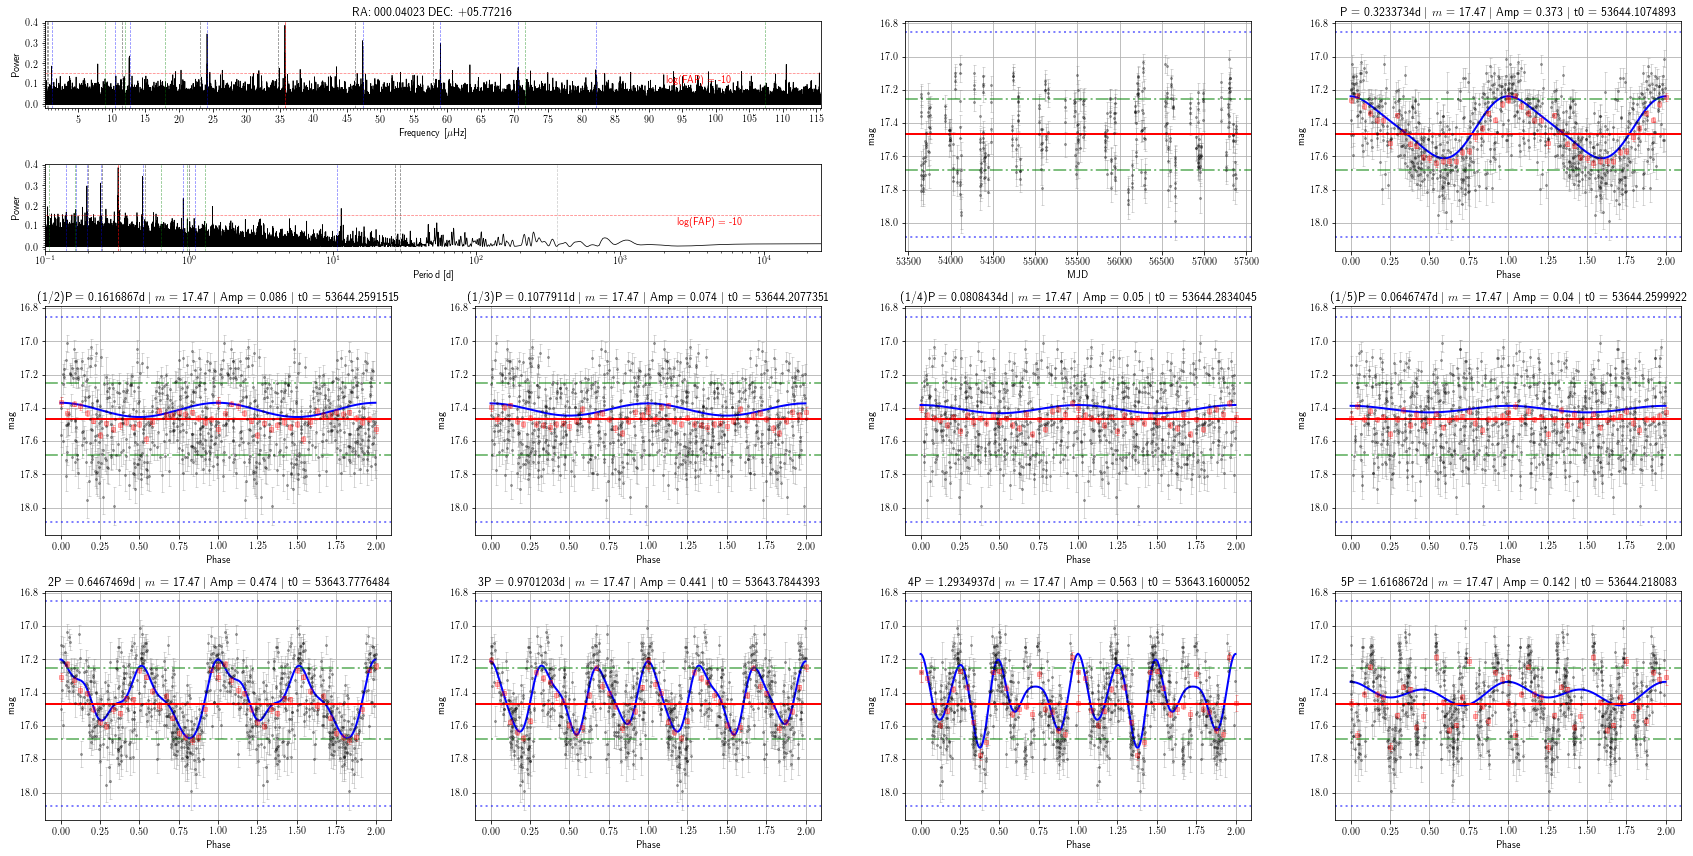

In [156]:
title = "RA: {!s} DEC: {!s}".format(ra_string, dec_string)
LCtools.plot_LC_analysis_ALLaliases(flc_data, P, freq_grid, power, FAP_power_peak=FAP_power_peak, logFAP_limit=logFAP_limit, df=df, title=title)

In [157]:
sorted_P = np.flip(freq2per(freq_grid[np.argsort(power)]))
X = sorted_P[:100].reshape(-1,1)
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique, labels_index, labels_inverse, labels_inverse = np.unique(labels, return_index=True, return_inverse=True, return_counts=True)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

P1 = X.flatten()[np.where(labels == np.argsort(labels_index)[0])[0][0]].value
P2 = X.flatten()[np.where(labels == np.argsort(labels_index)[1])[0][0]].value
P3 = X.flatten()[np.where(labels == np.argsort(labels_index)[2])[0][0]].value

print(f"The top 3 periods are: \n {P1}d \n {P2}d \n {P3}d")

number of estimated clusters : 3
The top 3 periods are: 
 0.32337343163885657d 
 0.9176669236134053d 
 11.499540018399262d


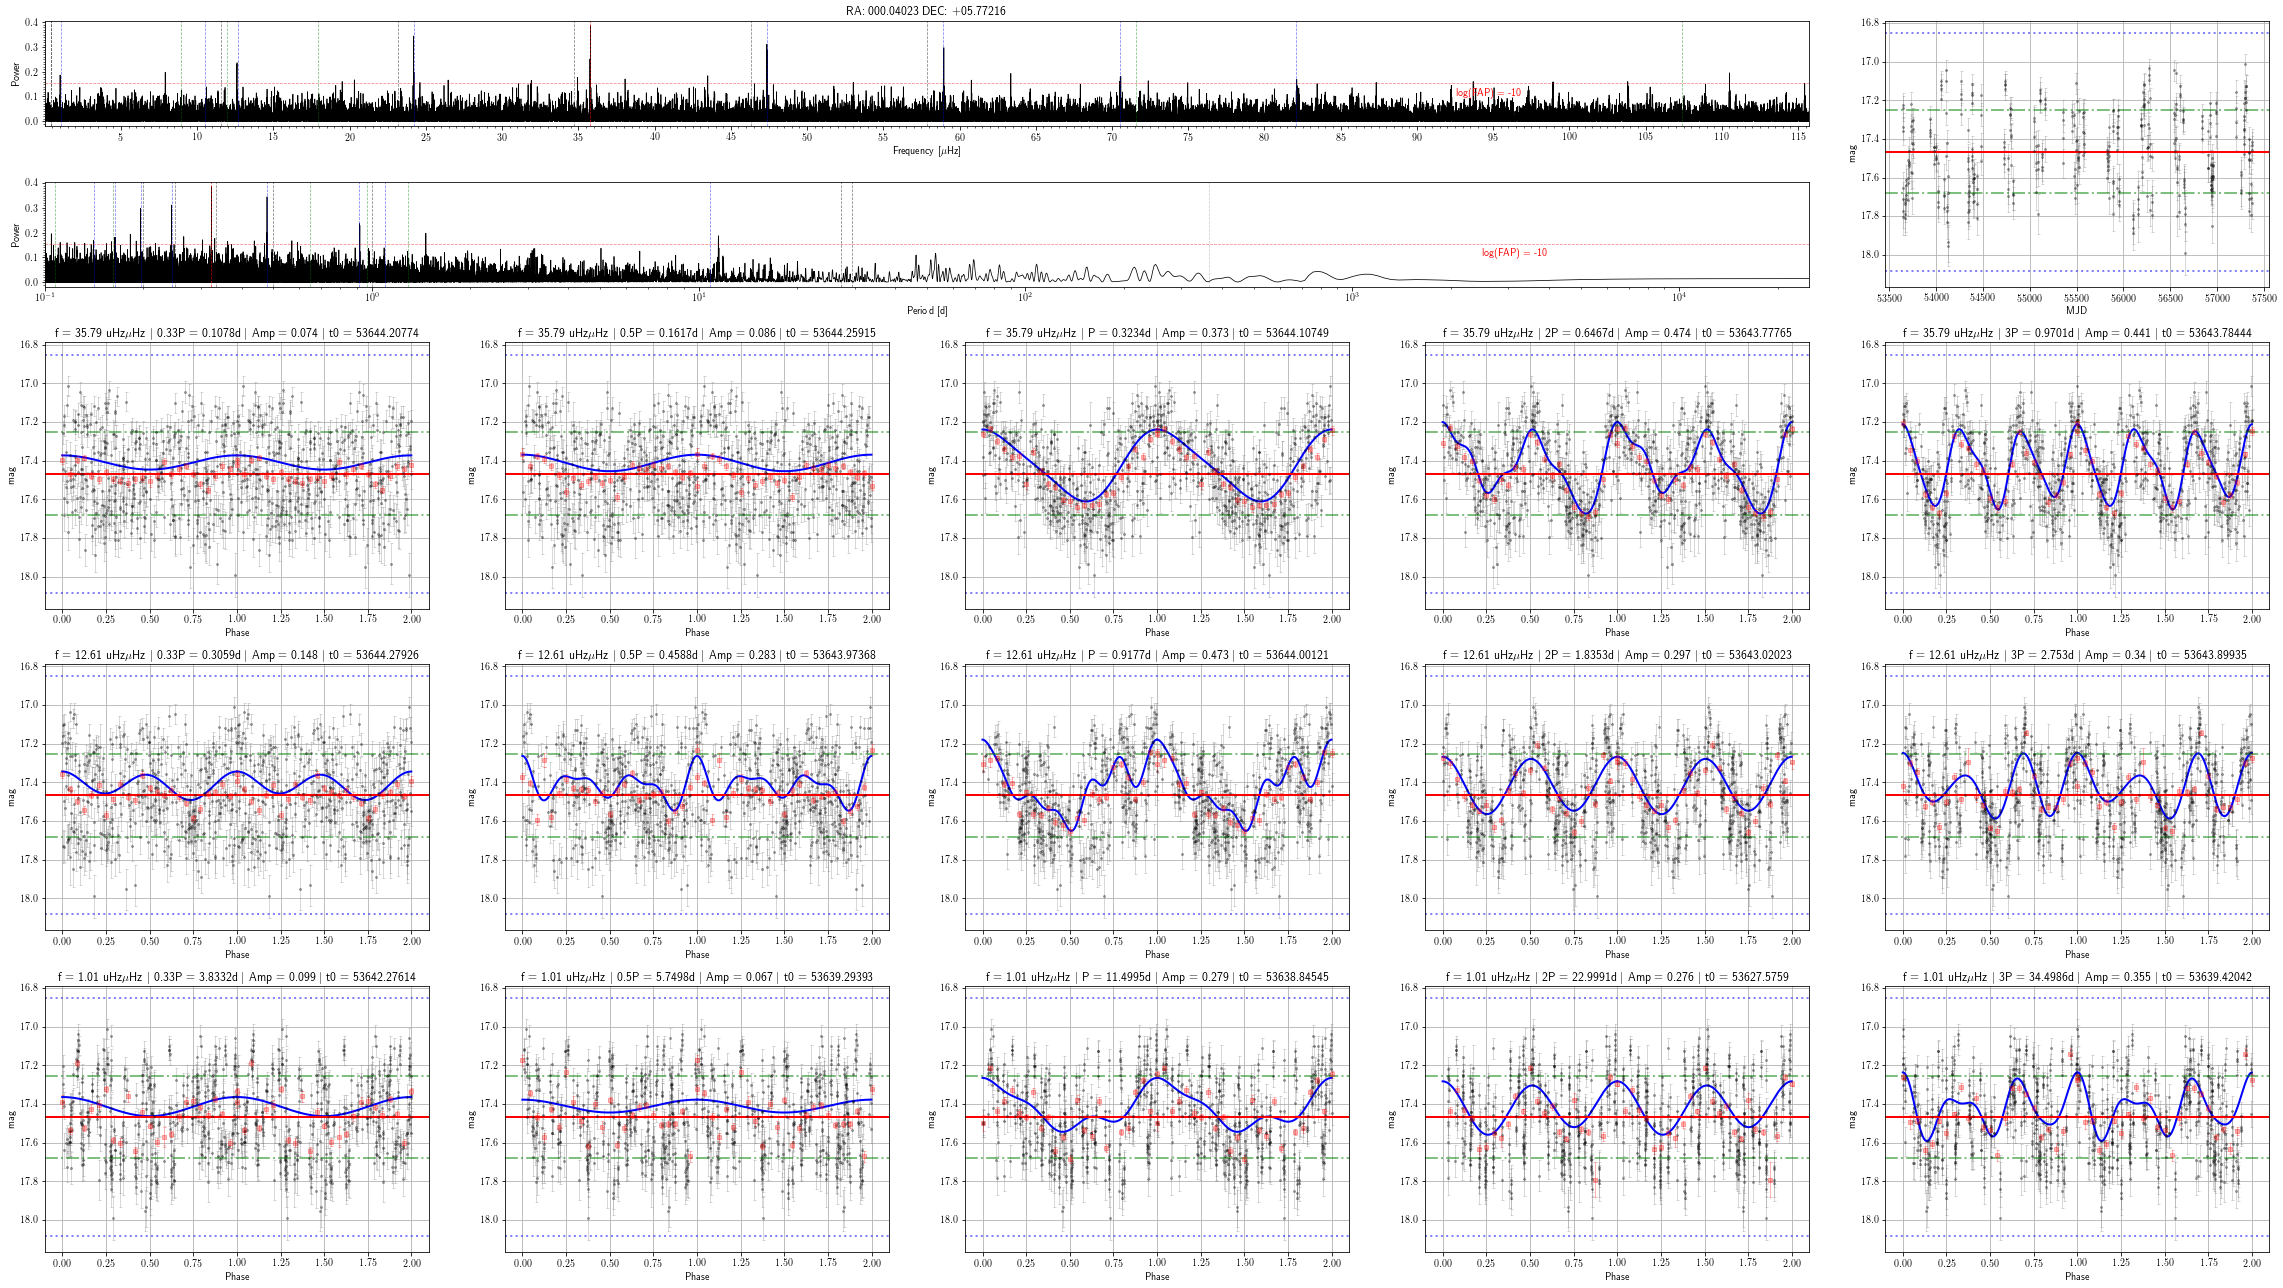

In [158]:
title = "RA: {!s} DEC: {!s}".format(ra_string, dec_string)
LCtools.plot_LC_analysis_Pal2013(flc_data, P1, P2, P3, freq_grid, power, FAP_power_peak=FAP_power_peak, logFAP_limit=logFAP_limit, df=df, title=title)
plt.savefig("188.53969+31.24791_LS_top3P.pdf", dpi=600)

In [19]:
def createHarmonicFrac(Nmax=4):
    hold = np.arange(2.0, Nmax + 1.0)
    return np.sort(np.hstack(([1], hold, hold**-1)))


def test_alias(P0, harmonics, t_days, y_mags, dy_mags, nterms=6):
    P0 = P0 * u.d
    model_ls = LombScargle(t_days, y_mags, dy_mags, fit_mean=True, center_data=True, nterms=nterms)

    resids = np.zeros(harmonics.size) * np.nan
    for ii, harm in enumerate(harmonics):
        P_test = harm * P0
        resids[ii] = np.nansum((((y_mags - model_ls.model(t=t_days, frequency=P_test**-1)) / dy_mags)**2)) * (1 / (t_days.size - 1))

    best_harmonic = harmonics[np.nanargmin(resids)]
    P = P0 * best_harmonic
    return P, best_harmonic, resids


In [159]:
P0 = P
harmonics = LCtools.createHarmonicFrac(Nmax=4)
lc_data= [t_days.value, y_mags.value, dy_mags.value]
Pbest, best_harmonic, harmonic_resids = LCtools.checkHarmonics(P0, harmonics, lc_data, nterms=6)

print(f"The best harmonic P is: P = {Pbest}, which is a harmonic of {best_harmonic} of the highest power P.")
print(f"The harmonic residuals are:")
for ii in range(harmonics.size):
    print(harmonics[ii].round(2), harmonic_resids[ii])

The best harmonic P is: P = 0.6467468632777131, which is a harmonic of 2.0 of the highest power P.
The harmonic residuals are:
0.25 8.767470528810891
0.33 8.695674325922653
0.5 8.642238990342404
1.0 5.340469736790928
2.0 5.0388395905123575
3.0 5.267676978265849
4.0 5.058323706825175


AFD Nterms: 6
AFD Nterms: 6


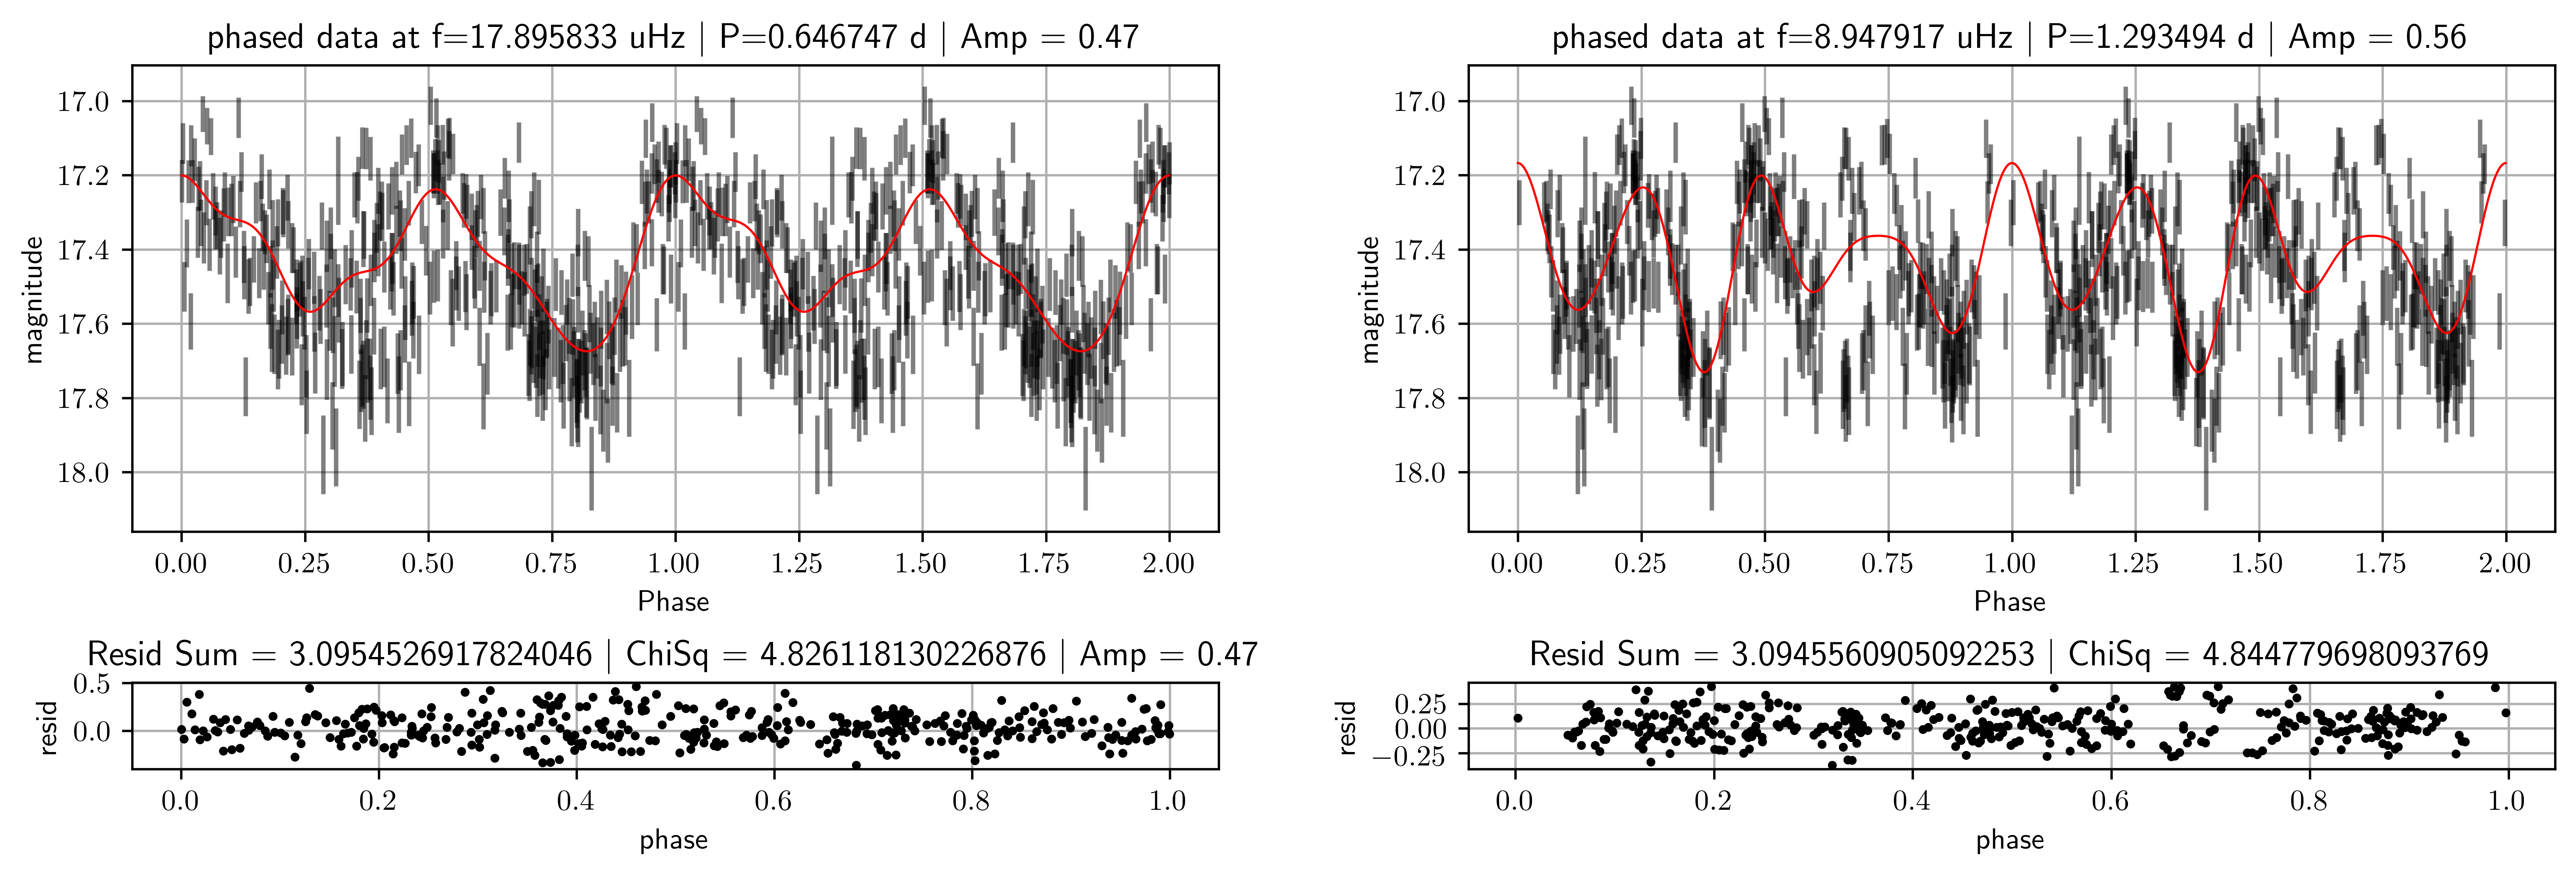

In [160]:
fig = plt.figure(figsize=(12, 4), constrained_layout=True, dpi=600)
gs = GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[:3, 0])
ax2 = fig.add_subplot(gs[3:, 0])
ax3 = fig.add_subplot(gs[:3, 1])
ax4 = fig.add_subplot(gs[3:, 1])

plot_P = 1.0 * Pbest * u.d
Nmax = 6

data = [t_days.value, y_mags.value, dy_mags.value]
AFD_data = LCtools.AFD(data, plot_P.value, alpha=0.99, Nmax=Nmax)
print(f"AFD Nterms: {AFD_data[0]}")

ax1.plot(AFD_data[1], AFD_data[2], c='r', lw=0.75)
ax1.plot(AFD_data[1] + 1, AFD_data[2], c='r', lw=0.75)
ax1.errorbar(AFD_data[3], y_mags.value, dy_mags.value, c='k', ls='None', alpha=0.5)
ax1.errorbar(AFD_data[3] + 1, y_mags.value, dy_mags.value, c='k', ls='None', alpha=0.5)

ax1.invert_yaxis()
ax1.set(xlabel='Phase',
       ylabel='magnitude',
       title='phased data at f={!s} $|$ P={!s} $|$ Amp = {!s}'.format(np.round((plot_P**-1).to(u.microHertz), 6), np.round(plot_P, 6), (AFD_data[2].max() - AFD_data[2].min()).round(2)))

ax1.grid(True)

resid = AFD_data[4]  # y_mags - model_ls.model(t=t_days, frequency=plot_P**-1)
resid_sum = np.nansum(resid**2)**0.5
ChiSq = np.nansum(resid**2 / dy_mags.value**2) / (y_mags.size - 1)

ax2.errorbar(AFD_data[3], resid, 0, c='k', marker=".", ls='None', mew=0, capsize=0, elinewidth=1.5)
ax2.set(xlabel='phase', ylabel='resid', title=f'Resid Sum = {resid_sum} $|$ ChiSq = {ChiSq} $|$ Amp = {(AFD_data[2].max() - AFD_data[2].min()).round(2)}')
ax2.grid(True)

# ************************************************************************************************************
# ************************************************************************************************************
# ************************************************************************************************************

plot_P = harmonics[np.argsort(harmonic_resids)[1]] * P0 * u.d

data = [t_days.value, y_mags.value, dy_mags.value]
AFD_data = LCtools.AFD(data, plot_P.value, alpha=0.99, Nmax=Nmax)
print(f"AFD Nterms: {AFD_data[0]}")

ax3.plot(AFD_data[1], AFD_data[2], c='r', lw=0.75)
ax3.plot(AFD_data[1] + 1, AFD_data[2], c='r', lw=0.75)
ax3.errorbar(AFD_data[3], y_mags.value, dy_mags.value, c='k', ls='None', alpha=0.5)
ax3.errorbar(AFD_data[3] + 1, y_mags.value, dy_mags.value, c='k', ls='None', alpha=0.5)

ax3.invert_yaxis()
ax3.set(xlabel='Phase',
       ylabel='magnitude',
       title='phased data at f={!s} $|$ P={!s} $|$ Amp = {!s}'.format(np.round((plot_P**-1).to(u.microHertz), 6), np.round(plot_P, 6), (AFD_data[2].max() - AFD_data[2].min()).round(2)))

ax3.grid(True)

resid = AFD_data[4]  # y_mags - model_ls.model(t=t_days, frequency=plot_P**-1)
resid_sum = np.nansum(resid**2)**0.5
ChiSq = np.nansum(resid**2 / dy_mags.value**2) / (y_mags.size - 1)

ax4.errorbar(AFD_data[3], resid, 0, c='k', marker=".", ls='None', mew=0, capsize=0, elinewidth=1.5)
ax4.set(xlabel='phase', ylabel='resid', title=f'Resid Sum = {resid_sum} $|$ ChiSq = {ChiSq}')
ax4.grid(True)

plt.show()

In [25]:
testing_P = 0.544425
A = 0.57
skew = 1.32
gmi = 0.9
print("P:", testing_P)
LCtools.dealias_Pal2013(testing_P, A, skew, gmi)

P: 0.544425


(0.544425, 'SingleMin')

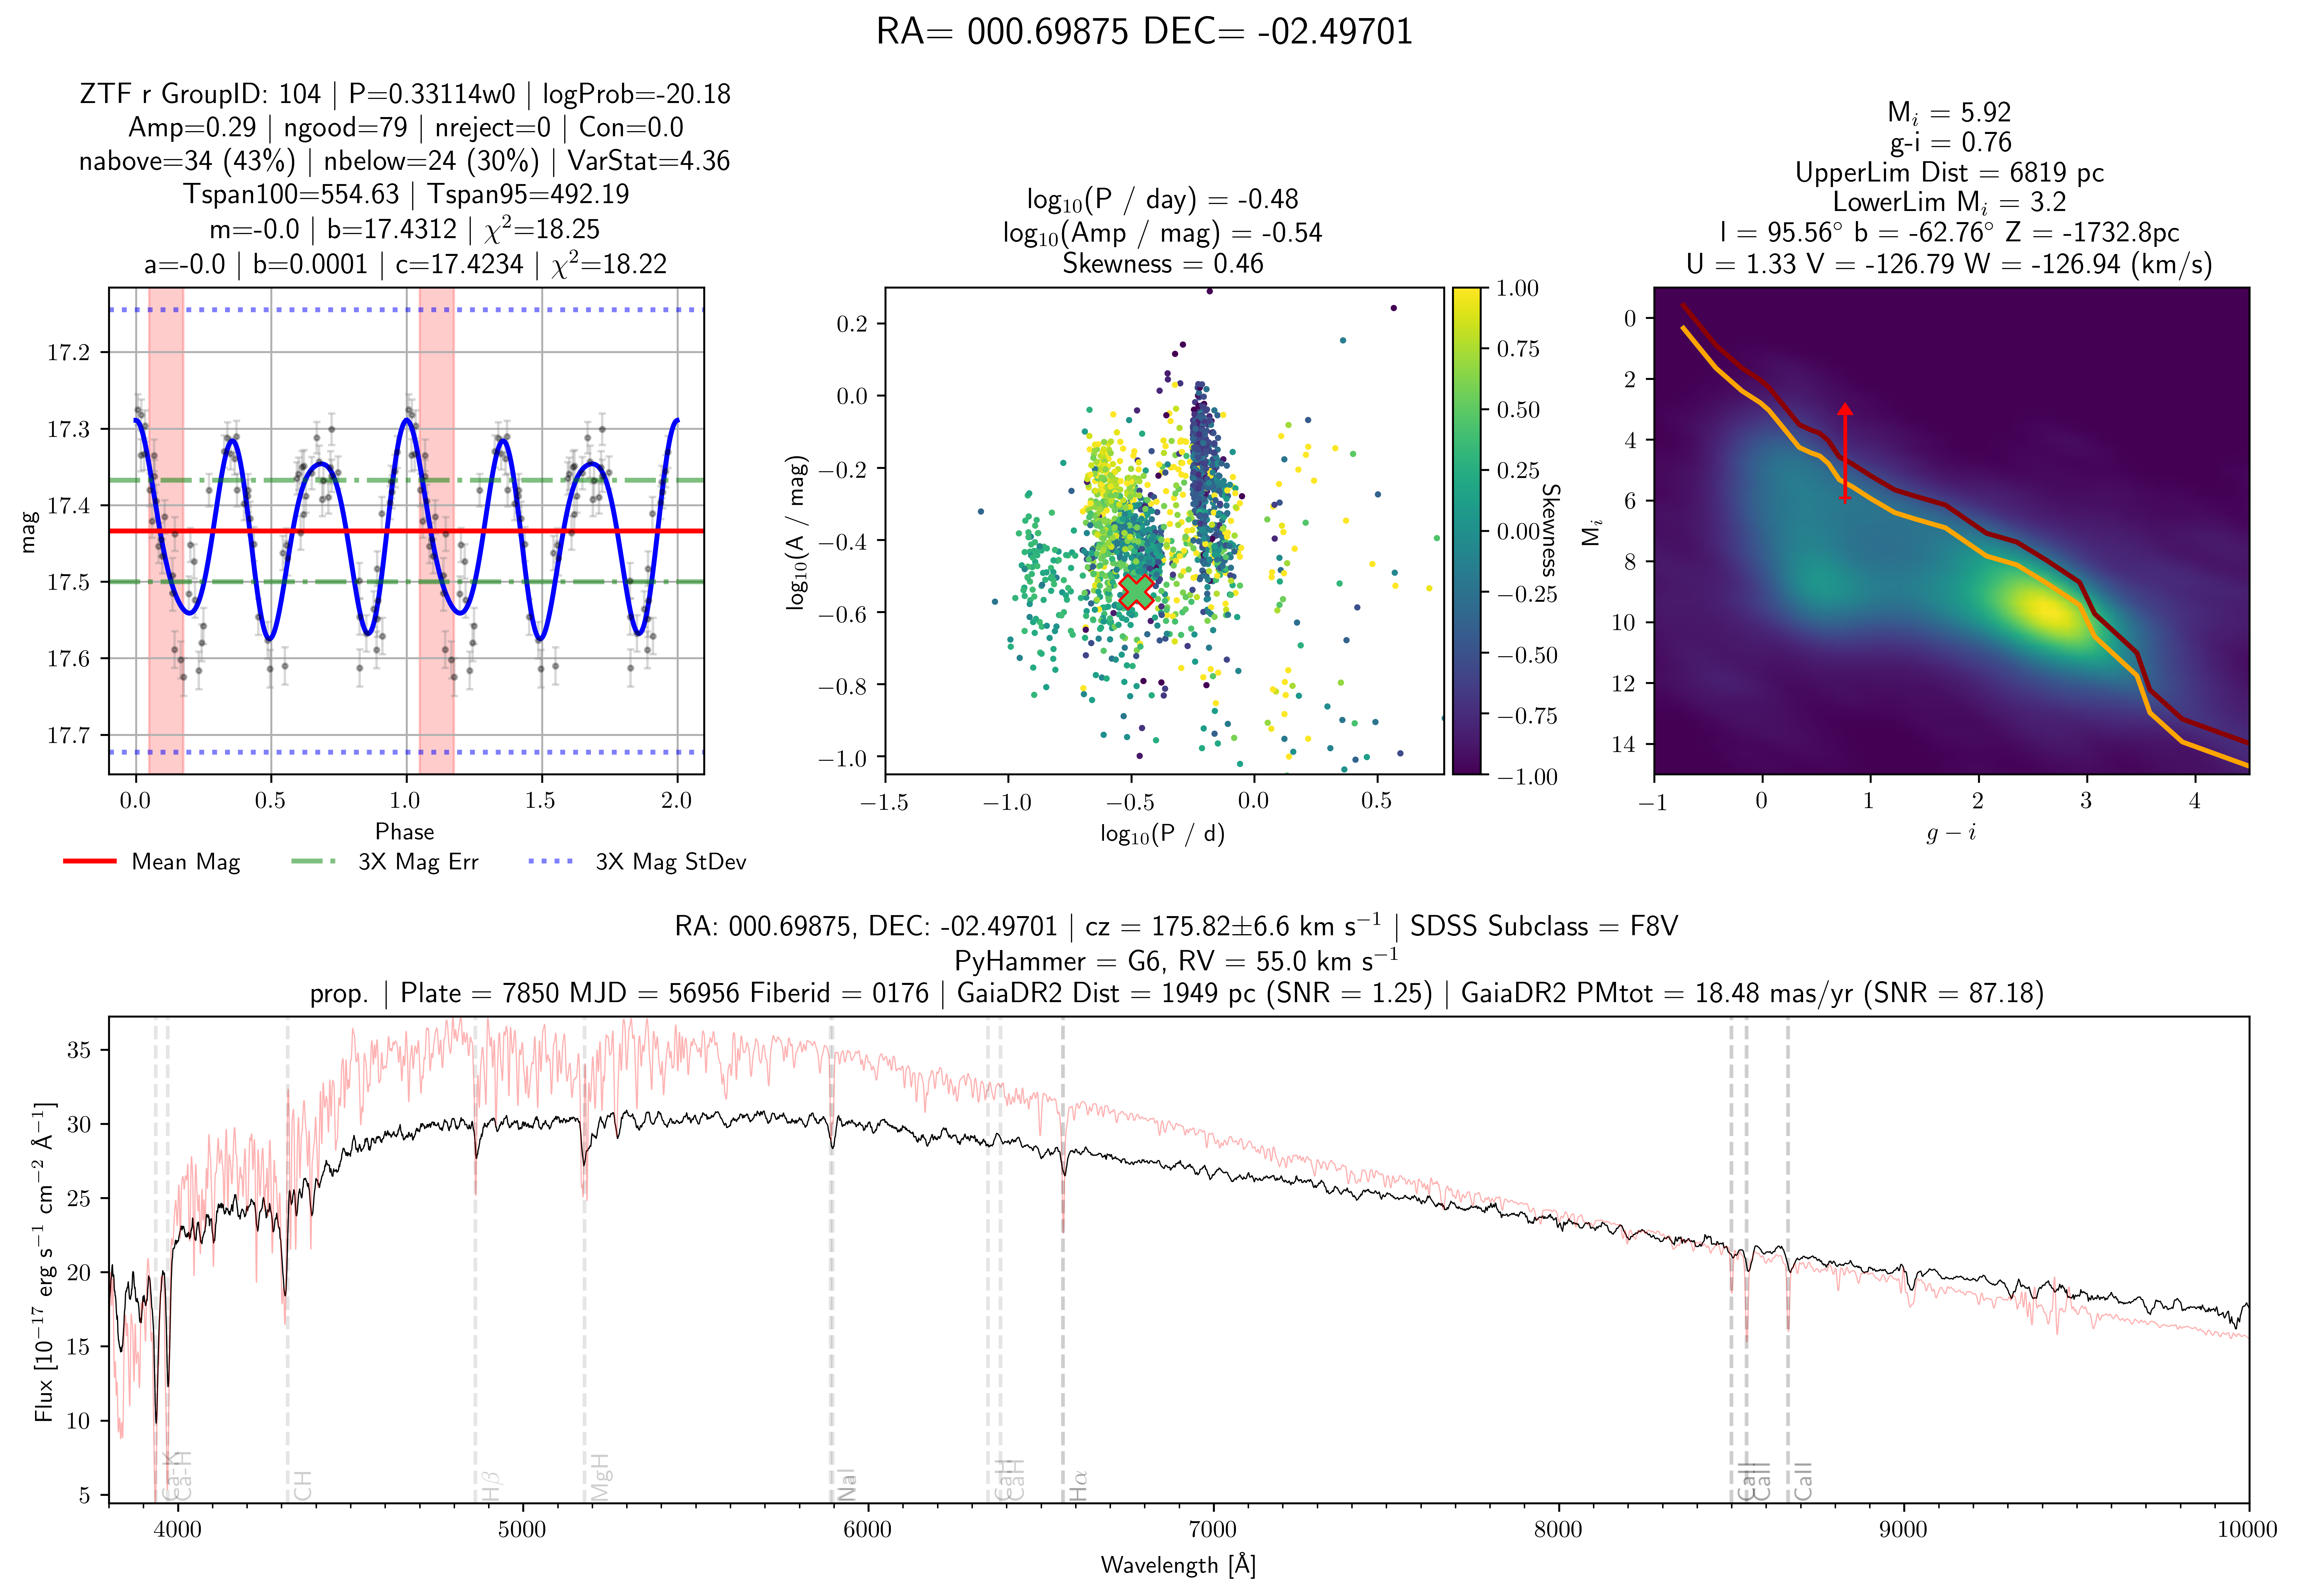

In [27]:
ROW = TDSSprop.data[prop_id]

object_ra = ROW['ra']
object_dec = ROW['dec']
ra_string = '{:0>9.5f}'.format(object_ra)
dec_string = '{:0=+9.5f}'.format(object_dec)

mjd = ROW['mjd']
plate = ROW['plate']
fiberid = ROW['fiber']
mjd_string = '{:0>5}'.format(str(np.int(mjd)))
plate_string = '{:0>4}'.format(str(np.int(plate)))
fiberid_string = '{:0>4}'.format(str(np.int(fiberid)))
long_filename = f"spec-{plate_string}-{mjd_string}-{fiberid_string}.fits"

fig = plt.figure(figsize=(13, 9), constrained_layout=True, dpi=600)
gs = GridSpec(2, 7, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1, 0.4, 1, 1])  # , hspace=0.3, wspace=0.5)
ax1 = fig.add_subplot(gs[0, :2])  # LC
ax2 = fig.add_subplot(gs[0, 2:4])  # Chi2 vs Amp plots OR Palerversa+2013 plot
ax3 = fig.add_subplot(gs[0, 5:])  # CMD
ax4 = fig.add_subplot(gs[1, :])  # spectra with lines
fig.suptitle(f'RA= {ra_string} DEC= {dec_string}', fontsize=16)

CSS_prop, ZTF_g_prop, ZTF_r_prop, best_LC = vi.LC_analysis(ROW, TDSSprop, CSS_LC_dir, ZTF_g_LCs, ZTF_r_LCs, ax1, CSS_LC_plot_dir, ZTF_LC_plot_dir, Nepochs_required, minP=minP, maxP=maxP, log10FAP=logProblimit, checkHarmonic=checkHarmonic, plt_subLC=plt_subLC, plot_rejected=plot_rejected)
all_LC_props = [CSS_prop, ZTF_g_prop, ZTF_r_prop]

this_EqW = vi.plot_SDSSspec(ROW, TDSSprop, prop_id, spec_dir, ax4)

vi.plot_middle(all_LC_props, best_LC, latestFullVartoolsRun, ax2, log10FAP=logProblimit)

vi.plot_CMD(TDSSprop, prop_id, ax3)

# plt.savefig(f"{Vi_plots_dir}{ra_string}{dec_string}_Vi.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
def dealias_Pal2013(P, A, skew, gmi):
    prop_array = np.array([np.log10(P), np.log10(A), skew, gmi])
    VarTypes = np.array(['RRab', 'RRc', 'single min', 'EA', 'EB/EW', 'delt Scut/SX Phe'])
    #                        P       A    skew   g-i
    lower_lims = np.array([[-0.36, -0.55, -1.2, -0.42],
                           [-0.59, -0.55, -0.4, -0.20],
                           [-0.60, -0.70, 0.32, -0.20],
                           [-0.60, -0.67, 1.00, -1.20],
                           [-0.67, -0.56, -0.1, 0.10],
                           [-1.38, -0.63, -1.0, -0.50]])
    #                        P       A    skew   g-i
    upper_lims = np.array([[-0.05, 0.05, 0.20, 0.50],
                           [-0.36, -0.15, 0.35, 0.35],
                           [np.inf, 0.00, 3.60, 3.00],
                           [np.inf, 0.14, 3.70, 3.80],
                           [-0.40, -0.09, 1.60, 1.80],
                           [-1.05, -0.12, 0.70, 0.20]])
    harmonics = LCtools.createHarmonicFrac(Nmax=4)
    test_prop_array = prop_array.copy()
    possible_types_for_harmonics = []
    for ii, harmonic in enumerate(harmonics):
        test_prop_array[0] = prop_array[0] + np.log10(harmonic)
        
        possible_types_index = np.all(((test_prop_array >= lower_lims) & (test_prop_array <= upper_lims)), axis=1)
        possible_types_for_harmonics.append(VarTypes[possible_types_index])
        print(harmonic, test_prop_array, 10.0**test_prop_array[0])
    
    
    possible_types_index = np.all(((prop_array >= lower_lims) & (prop_array <= upper_lims)), axis=1)
    possible_types = VarTypes[possible_types_index]
    
    if (-0.55 <= np.log10(A) <= +0.30) & (-1.20 <= skew <= +0.20) & (-0.42 <= gmi <= +0.50):  # (RRab)
        if (-0.36 <= np.log10(P) <= -0.05):
            true_P = P
        elif (np.log10(P) < -0.36):
            true_P = P * 2
        elif (np.log10(P) > -0.05):
            true_P = P * 0.5
        VarType = 'RRab'
        return true_P, VarType
    if (-0.55 <= np.log10(A) <= -0.15) & (-0.40 <= skew <= +0.35) & (-0.20 <= gmi <= +0.35):  # (RRc)
        if (-0.59 <= np.log10(P) <= -0.36):
            true_P = P
            VarType = 'RRc'
            return true_P, VarType
    if (-0.7 <= np.log10(A) <= +0.00) & (0.32 <= skew <= 3.6) & (-0.2 <= gmi <= 3.0):  # (Single min)
        if (-0.6 <= np.log10(P)):
            true_P = P
            VarType = 'SingleMin'
            return true_P, VarType
    if (-0.67 <= np.log10(A) <= 0.14) & (+1.00 <= skew <= 3.70) & (-1.20 <= gmi <= 3.80):  # Algol (EA)
        if (-0.6 <= np.log10(P)):
            true_P = P
            VarType = 'EA'
            return true_P, VarType
        elif (-0.6 <= np.log10(2*P)):
            true_P = 2*P
            VarType = "EA"
            return true_P, VarType
    if (-0.56 <= np.log10(A) <= -0.09) & (-0.10 <= skew <= +1.60) & (+0.10 <= gmi <= +1.80):  # β Lyr and W UMa (EB/EW)
        if (-0.67 <= np.log10(P) <= -0.40):
            true_P = P
            VarType = 'EB/EW'
            return true_P, VarType
        elif (-0.67 <= np.log10(2 * P) <= -0.40):
            true_P = 2 * P
            VarType = 'EB/EW'
            return true_P, VarType
    if (-0.63 <= np.log10(A) <= -0.12) & (-1.00 <= skew <= +0.70) & (-0.50 <= gmi <= +0.20):  # SX Phe/δ Sct (deltScut)
        if (-1.38 <= np.log10(P) <= -1.05):
            true_P = P
            VarType = 'SXPhe/deltScut'
            return true_P, VarType

    true_P = None
    VarType = "Unknown"
    return true_P, VarType


P = 0.64675
A = 0.47
skew = -0.01
gmi = 0.2
dealias_Pal2013(P, A, skew, gmi)